In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from utilities import retrieve_data
import calendar

ERA_VERSION = 'ERA5'  # One day this will change to ERA6

# ====================
# To get a CDS API key, sign up at https://cds.climate.copernicus.eu/
# It is free and easy! After registering, copy your "Personal Access Token here"
# ====================
KEY = '############################'
KEY = '6cc2b53b-e3c0-42fd-b7ad-db64aeeb5298'
KEY = '8f3ee43a-fa64-4eb9-a403-6567171bb625'

# ====================
# Change these to plot different locations. You can see the currently used ones in the ERA Explorer URL
# ====================
lat = 50.86  # Default latitude
lng = 4.35  # Default longitude

# ====================
# These can be changed to get different data; leave them for now
# ====================
variable = "2m_temperature"
date_range = ["1991-01-01", "2020-12-31"]

# ====================
# Get the data. This will download a NetCDF file
# ====================
data_file = retrieve_data(KEY, variable, date_range, lat, lng)

{'variable': ['2m_temperature'], 'date': ['1991-01-01/2020-12-31'], 'location': {'longitude': 4.35, 'latitude': 50.86}, 'data_format': 'netcdf'}
2m_temperature_1991-01-01_2020-12-31_50.86_4.35.nc


2024-12-04 13:33:26,192 INFO [2024-07-18T00:00:00] Remember that you need to have an ECMWF account to use CDS-Beta. **Your existing CDS credentials will not work in CDS-Beta!**
2024-12-04 13:33:26,193 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2024-12-04 13:33:26,193 WARNING [2024-06-16T00:00:00] Check our [informative page](https://confluence.ecmwf.int/x/uINmFw) to best prepare yourself to use CDS-Beta.
2024-12-04 13:33:26,194 WARNING [2024-06-16T00:00:00] **BETA version** of the new CDS. Your [feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is very useful for us. **Please notice** that access to the system might suffer some disruptions due to evolving updates.
2024-12-04 13:33:26,388 INFO Request ID is 2396712f-7442-46ce-82c6-8b

Retrieving data in to:  2m_temperature_1991-01-01_2020-12-31_50.86_4.35.nc


In [2]:
# Make a function to compute the monthly temperature climatology
def temperatureMonthlyClimatology():
    """
    Processes temperature data to calculate monthly climatology and thresholds.
    This function reads temperature data from a NetCDF file, processes it to calculate
    daily minimum and maximum temperatures, and then computes monthly climatology
    statistics. It also calculates the percentage of frost days, tropical nights, and
    summer days per month over a 30-year period.
    Returns:
        tuple: A tuple containing the following elements:
            - monthly_climatology (pd.DataFrame): Climatological averages for daily minimum
              and maximum temperatures per month, converted to Celsius.
            - frost_day_climatology (pd.Series): Average percentage of frost days per month.
            - tropical_night_climatology (pd.Series): Average percentage of tropical nights per month.
            - summer_day_climatology (pd.Series): Average percentage of summer days per month.
    """
        
    data_t2m_pt = xr.open_dataset(data_file).t2m

    # Convert the time coordinate to a pandas datetime index
    time_index = pd.to_datetime(data_t2m_pt.valid_time.values)
    
    # Create a DataFrame for easier manipulation
    df = pd.DataFrame(data_t2m_pt.values, index=time_index, columns=['t2m'])
    
    # Resample to find daily minimum and maximum
    daily_min = df.resample('D').min()
    daily_max = df.resample('D').max()
    
    # Combine the daily min and max into a single DataFrame
    daily_stats = pd.DataFrame({
        'daily_min': daily_min['t2m'],
        'daily_max': daily_max['t2m']
    })

    # Define the frost night threshold (e.g., 0°C in Kelvin)
    frostDayThreshold = 0 + 273.15
    tropicalNightThreshold = 20 + 273.15
    summerDayThreshold = 25 + 273.15
    
    # Check if the daily minimum is below the threshold
    daily_min['frost_day'] = daily_min['t2m'] < frostDayThreshold
    daily_min['tropical_night'] = daily_min['t2m'] > tropicalNightThreshold
    daily_max['summer_day'] = daily_max['t2m'] > summerDayThreshold
    
    # Count the number of frost days (days below the threshold) per month
    frost_day_counts = daily_min.resample('ME').sum()['frost_day']
    tropical_night_counts = daily_min.resample('ME').sum()['tropical_night']
    summer_day_counts = daily_max.resample('ME').sum()['summer_day']

    # Count the total number of days per month
    total_days_per_month = daily_min.resample('ME').size()

    # Calculate the percentage of frost nights per month
    frost_day_percent = (frost_day_counts / total_days_per_month) * 100
    tropical_night_percent = (tropical_night_counts / total_days_per_month) * 100
    summer_day_percent = (summer_day_counts / total_days_per_month) * 100
    
    # Convert the index to month
    frost_day_percent.index = frost_day_percent.index.month
    tropical_night_percent.index = tropical_night_percent.index.month
    summer_day_percent.index = summer_day_percent.index.month
    
    # Group by month and calculate the average percentage over the 30-year period
    frost_day_climatology = frost_day_percent.groupby(frost_day_percent.index).mean()
    tropical_night_climatology = tropical_night_percent.groupby(tropical_night_percent.index).mean()
    summer_day_climatology = summer_day_percent.groupby(summer_day_percent.index).mean()

    # Extract the month from DateTimeIndex
    daily_stats['month'] = daily_stats.index.month
    
    # Group by month and calculate climatological averages for daily min and max
    grouped_by_month = daily_stats.groupby('month')
    monthly_climatology = grouped_by_month.mean() - 273.15  # Convert to Celsius
    
    return monthly_climatology, frost_day_climatology, tropical_night_climatology, summer_day_climatology

# Call our function
clim, frost_clim, tropical_clim, summer_clim = temperatureMonthlyClimatology()

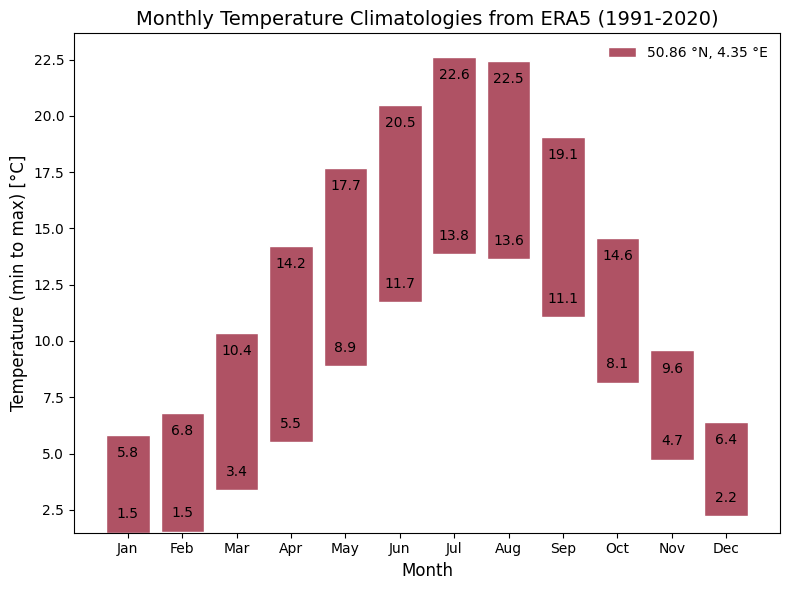

In [3]:
# Make the plot
lw = 2
marker = 'o'
markersize = 4

latSuffix = 'N' if lat > 0 else 'S'
lngSuffix = 'E' if lng > 0 else 'W'

plt.figure(figsize=(8, 6))

# Plot the data as a bar chart
bars = plt.bar(
    clim.index,
    clim['daily_max'] - clim['daily_min'],
    bottom=clim['daily_min'],
    width=0.8,
    color='#AF5264',
    edgecolor='white',
    label=f'{abs(lat):.2f} °{latSuffix:s}, {abs(lng):.2f} °{lngSuffix:s}'
)

# Add labels to each bar
for index, bar in enumerate(bars):
    daily_min = clim['daily_min'].iloc[index]
    daily_max = clim['daily_max'].iloc[index]
    
    # Compute positions for the text
    x = bar.get_x() + bar.get_width() / 2  # Center of the bar
    
    # Add the labels (daily_min and daily_max) on two lines
    plt.text(
        x,  # X position
        bar.get_y() + 0.5,
        f'{daily_min:.1f}',  # Label text with new line
        ha='center',  # Center horizontally
        va='bottom',  # Align below the top of the bar
        fontsize=10,  # Font size
        color='black'  # Text color
    )

     # Add the labels (daily_min and daily_max) on two lines
    plt.text(
        x,  # X position
        bar.get_height() + bar.get_y() - 0.5,
        f'{daily_max:.1f}',  # Label text with new line
        ha='center',  # Center horizontally
        va='top',  # Align below the top of the bar
        fontsize=10,  # Font size
        color='black'  # Text color
    )


# Add legend
plt.legend(framealpha=0)

# Customize x and y axis labels
plt.xlabel('Month', fontsize=12)
plt.ylabel('Temperature (min to max) [°C]', fontsize=12)

# Set x-ticks to month labels
plt.xticks(ticks=clim.index, labels=[calendar.month_abbr[i] for i in clim.index])

# Add title with custom font
plt.title(f'Monthly Temperature Climatologies from {ERA_VERSION} ({date_range[0][:4]}-{date_range[1][:4]})', fontsize=14)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()